In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Bryan Cheong\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import os
import gc
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import torchvision.transforms.functional as TF
from torch import Tensor

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

Image Preprocessing

In [2]:
def apply_gamma_correction(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def clahe_and_gamma_correction_apply_and_save(input_dir, output_dir, gamma=1.0, clipLimit=2.0, tileSize=(8, 8)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff']
    
    for ext in image_extensions:
        image_paths = glob.glob(os.path.join(input_dir, ext))
        print(f"Found {len(image_paths)} images with extension {ext}")
        
        for img_path in image_paths:
            filename = os.path.basename(img_path)

            # Read the image in grayscale mode
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Apply Gamma Correction
            image_gamma_corrected = apply_gamma_correction(image, gamma=gamma)
            
            # Then, Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileSize)
            image_clahe = clahe.apply(image_gamma_corrected)
            
            # Save the processed image
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, image_clahe)
            print(f"Processed and saved {filename} to {output_dir}")

input_dir = './Merged_Dataset/raw_images'
output_dir = './Merged_Dataset/CLAHE'

# Choose an appropriate gamma value based on your need
gamma_value = 1.1  # Example gamma value, adjust based on your images' needs
clahe_and_gamma_correction_apply_and_save(input_dir, output_dir, gamma=gamma_value)


Found 0 images with extension *.png
Found 73 images with extension *.jpg
Processed and saved 01_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 01_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 01_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 02_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 02_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 02_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 03_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 03_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 03_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 04_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 04_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 04_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 05_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 05_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 05_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 06_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 06_g.jpg to ./Merged_

In [48]:
'''def clahe_apply_and_save(input_dir, output_dir, clipLimit=2.0, tileSize=(8, 8)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    # List of image file extensions to include for the input images
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.tif', '*.tiff']
    
    for ext in image_extensions:
        image_paths = glob.glob(os.path.join(input_dir, ext))
        print(f"Found {len(image_paths)} images with extension {ext}")
        
        for img_path in image_paths:
            filename = os.path.basename(img_path)

            # Read the image
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Ensure images are read in grayscale mode
            
            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileSize)
            image_clahe = clahe.apply(image)
            
            # Save the CLAHE-processed image
            save_path = os.path.join(output_dir, filename)
            cv2.imwrite(save_path, image_clahe)
            print(f"Processed and saved {filename} to {output_dir}")

# Update these paths according to your dataset structure
input_dir = './Merged_Dataset/raw_images'
output_dir = './Merged_Dataset/CLAHE'

clahe_apply_and_save(input_dir, output_dir)

Found 0 images with extension *.png
Found 73 images with extension *.jpg
Processed and saved 01_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 01_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 01_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 02_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 02_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 02_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 03_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 03_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 03_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 04_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 04_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 04_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 05_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 05_g.jpg to ./Merged_Dataset/CLAHE
Processed and saved 05_h.jpg to ./Merged_Dataset/CLAHE
Processed and saved 06_dr.JPG to ./Merged_Dataset/CLAHE
Processed and saved 06_g.jpg to ./Merged_

Image Segmentation

In [2]:
class CustomTransform:
    def __init__(self, image_transform=None, mask_transform=None):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        # Apply random geometric transformations identically to both image and mask
        if random.random() > 0.5:
            image, mask = TF.vflip(image), TF.vflip(mask)
        if random.random() > 0.5:
            image, mask = TF.hflip(image), TF.hflip(mask)
        # Apply random rotation
        angle = random.uniform(-45, 45)
        image, mask = TF.rotate(image, angle), TF.rotate(mask, angle)
        
        # Apply other transformations to the image
        if self.image_transform is not None:
            image = self.image_transform(image)
        
        # Apply transformations to the mask if any
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        
        return image, mask

In [3]:
class RetinopathyDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.images = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        base_filename, _ = os.path.splitext(self.images[idx])
        label_path = self._find_matching_mask_file(base_filename)

        image = Image.open(img_path).convert("L")
        mask = Image.open(label_path).convert("L")

        if self.transform:
            image, mask = self.transform(image, mask)
        else:
            # If no transform is specified, just convert mask to a tensor
            mask = transforms.ToTensor()(mask)
            image = transforms.ToTensor()(image)
            mask = (mask > 0).float()

        return image, mask
    
    def _find_matching_mask_file(self, base_filename):
        for ext in ['.png', '.jpg', '.jpeg', '.tif', '.tiff', '.gif']:
            candidate_path = os.path.join(self.labels_dir, f"{base_filename}{ext}")
            if os.path.exists(candidate_path):
                return candidate_path
        raise FileNotFoundError(f"No matching mask file found for {base_filename}.")

In [4]:
images_dir = './Merged_Dataset/CLAHE'
labels_dir = './Merged_Dataset/manual_labels'

In [5]:
calc_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
])

calc_mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize masks similarly to ensure matching dimensions
    transforms.ToTensor(),
])

# Initialize CustomTransform with both image and mask transforms
calc_custom_transform = CustomTransform(image_transform=calc_image_transform, mask_transform=calc_mask_transform)

In [6]:
dataset_for_calc = RetinopathyDataset(images_dir, labels_dir, transform=calc_custom_transform)

loader_for_calc = DataLoader(dataset_for_calc, batch_size=4, shuffle=False)

In [7]:
class conv_block(torch.nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super(conv_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.bn1(self.conv1(inputs)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class encoder_block(torch.nn.Module):
    def __init__(self, in_channels:int, out_channels:int):
        super(encoder_block, self).__init__()
        self.conv = conv_block(in_channels, out_channels)
        self.maxpool = torch.nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.maxpool(x)
        return x, p

class decoder(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(decoder, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = conv_block(out_channels+out_channels, out_channels)

  def forward(self, inputs, skip_connections):
    x = self.upsample(inputs)
    x = torch.cat((x, skip_connections), 1)
    return self.conv(x)


class uNetModel(torch.nn.Module):
    def __init__(self):
        super(uNetModel, self).__init__()
        # Encoder
        self.encoder1 = encoder_block(1, 64)  # Adjusted for 1 input channel
        self.encoder2 = encoder_block(64, 128)
        self.encoder3 = encoder_block(128, 256)
        self.encoder4 = encoder_block(256, 512)

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Decoder
        self.decoder1 = decoder(1024, 512)
        self.decoder2 = decoder(512, 256)
        self.decoder3 = decoder(256, 128)
        self.decoder4 = decoder(128, 64)

        # Classifier
        self.classifier = torch.nn.Conv2d(64, 1, 1)  # Adjusted for 1 output channel

    def forward(self, inputs):
        x1, p1 = self.encoder1(inputs)
        x2, p2 = self.encoder2(p1)
        x3, p3 = self.encoder3(p2)
        x4, p4 = self.encoder4(p3)
        b = self.bottleneck(p4)

        d1 = self.decoder1(b, x4)
        d2 = self.decoder2(d1, x3)
        d3 = self.decoder3(d2, x2)
        d4 = self.decoder4(d3, x1)

        output = self.classifier(d4)
        return output


In [8]:

# Initialize variables for mean and count
mean_sum = torch.zeros(1)
count = 0

# First pass to calculate mean
for images, _ in loader_for_calc:
    images_flattened = images.view(images.size(0), images.size(1), -1)
    mean_sum += images_flattened.mean(2).sum(0)
    count += images.size(0)
mean = mean_sum / count

# Initialize variables for sum of squares
sum_of_squares = torch.zeros(1)

# Second pass to calculate variance (and then standard deviation)
for images, _ in loader_for_calc:
    images_flattened = images.view(images.size(0), images.size(1), -1)
    # Use the previously computed mean for variance calculation
    sum_of_squares += ((images_flattened - mean.unsqueeze(-1)).pow(2)).sum(2).sum(0)
variance = sum_of_squares / count
std = torch.sqrt(variance)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.3358])
Std: tensor([48.4296])


In [42]:
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3347], std=[48.6151])  
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Include resizing
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float())  # Assuming masks are binary
])

# Initialize CustomTransform with both image and mask transforms
custom_transform = CustomTransform(image_transform=image_transform, mask_transform=mask_transform)

# Dataset initialization
dataset = RetinopathyDataset(images_dir, labels_dir, transform=custom_transform)
loader = DataLoader(dataset, batch_size=6, shuffle=True) #original batch size 6

In [43]:
def one_hot_encode(n_classes:int, y:Tensor):
    """
    Function that converts input into tensor with one hot encoding for each class
    Eg. [1,2,0,1,1] -> [[0, 0, 1, 0, 0], [1, 0, 0, 1, 1], [0, 1, 0, 0, 0]]

    Args:
        n_classes (int): number of classes in y
        y (Tensor): input to be split into one hot encoding

    Returns:
        tensor object of one hot encoding
    """
    y = y.long() #convert to ints first (class values)
    batch_size, _, height, width = y.size()
    one_hot = torch.zeros(batch_size, n_classes, height, width, device=y.device) #create base case
    return one_hot.scatter_(1, y, 1)


class DiceLoss(torch.nn.Module):
    """
    Function to calculate Dice Loss
        DL(y,p) = 1 - 2(yp + e) / (y + p + e) 
    
    where y = y_true, p = y_pred, e = epsilon to ensure no divisible by 0

    Args:
        n_classes (int): number of classes 
        reduction (str, optional): Reduction method, either only mean or sum. Defaults to mean
        eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.

    Returns:
        dice loss
    """
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.epsilon = eps
        
        if reduction in ["mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        assert y_true.size() == y_pred.size() #checking pred and true has the same size

        intersection = (y_pred * y_true).sum(dim=(2, 3)) #yp
        union = y_pred.sum(dim=(2,3)) + y_true.sum(dim=(2,3)) #y+p

        soft_dice_loss = (2.0* (intersection + self.epsilon)) / (union + self.epsilon)
        
        if self.reduction  == "mean":
            return 1.0 - torch.mean(soft_dice_loss)
        
        else:
            return 1.0 - torch.sum(soft_dice_loss)



class FocalLoss(torch.nn.Module):
    """
    Function to calculate Focal Loss
        FL(p, y) = -alpha * ((1-pt) ** gamma) * log(pt) 
    where log(pt) is the cross entropy loss, p = prediction, y = true value

    Args:
        n_classes (int): num of classes
        alpha (float, optional): alpha value, adds weights to help with class imbalance. Defaults to 0.25.
        gamma (float, optional): gamma value, controls the shape of loss curve for pioritising. Defaults to 2.0.
        reduction (str, optional): reudction method, either none, mean or sum. Defaults to "mean".
    """
    def __init__(self, n_classes:int, weights:Tensor=None, alpha:float=0.75, gamma:float=2.0, reduction:str="mean"):
        super(FocalLoss, self).__init__()
        self.n_classes = n_classes
        self.weights = weights
        self.alpha = alpha
        self.gamma = gamma

        if reduction in ["none", "mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between none, mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y_true.float(), pos_weight=self.weights, reduction=self.reduction) #-log(pt)
            

        if self.n_classes > 1: #multiclass classification
            y_true = torch.squeeze(y_true.long(), dim=1) #squeeze class layer as cross entropy expect (batch_size, h, w)
            loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=self.weights,  reduction=self.reduction) #-log(pt)

        exp_loss = torch.exp(-loss) #pt
        focal_loss = self.alpha * torch.pow((1.0-exp_loss), self.gamma) * loss
        #reduction already done in the loss calculation, just return focal loss

        return focal_loss
    


class TverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, eps:float=1e-6):
        super(TverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.beta = beta
        self.eps = eps

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        true_positive = (y_pred * y_true).sum(dim=(2, 3)) #yp
        false_negative =  ((1-y_pred) * y_true).sum(dim=(2,3)) #(1-p)y
        false_positive = (y_pred * (1-y_true)).sum(dim=(2,3)) #(1-y)p

        tversky_loss = true_positive / (true_positive + self.beta*false_negative + (1-self.beta)*false_positive + self.eps)
        return 1- torch.mean(tversky_loss)
    


class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, gamma:float=0.75, eps:float=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.treversky = TverskyLoss(n_classes, beta, eps)
        self.gamma = gamma

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        treversky_loss = self.treversky(y_pred, y_true)
        focal_tversky_loss = torch.pow(treversky_loss, self.gamma)
        return focal_tversky_loss


class LogCoshDice(torch.nn.Module):
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(LogCoshDice, self).__init__()
        self.diceloss = DiceLoss(n_classes, reduction, eps)

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        dice_loss = self.diceloss(y_pred, y_true)
        return torch.log(torch.cosh(dice_loss))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

negative_samples = 239247
positive_samples = 22897

# Calculate the weight for the positive class
pos_weight_value = 6
#negative_samples / positive_samples

# Convert to a tensor
pos_weight = torch.tensor([pos_weight_value]).to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22044\2794835854.py:11: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  pos_weight = torch.tensor([pos_weight_value]).to(device)


In [13]:
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion=FocalTverskyLoss

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = uNetModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCEWithLogitsLoss()

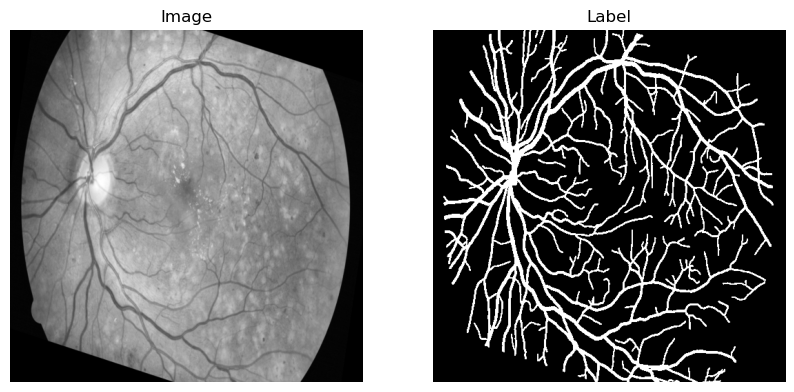

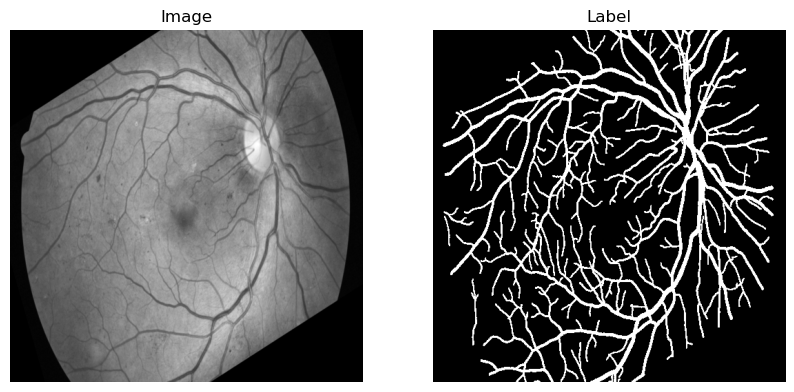

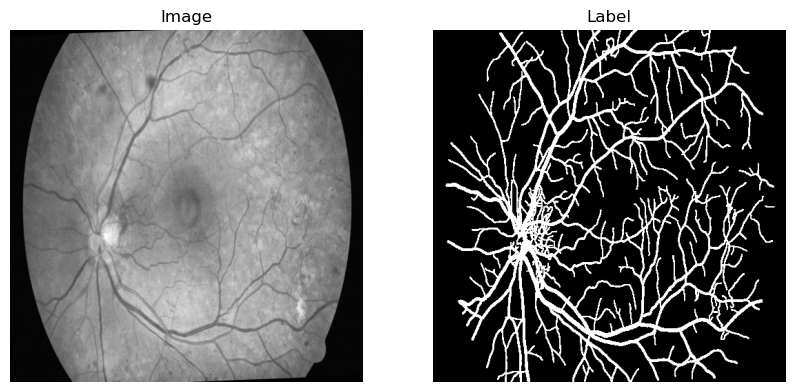

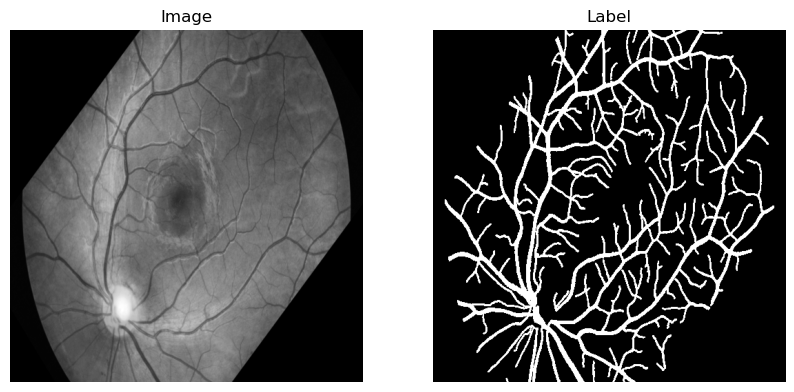

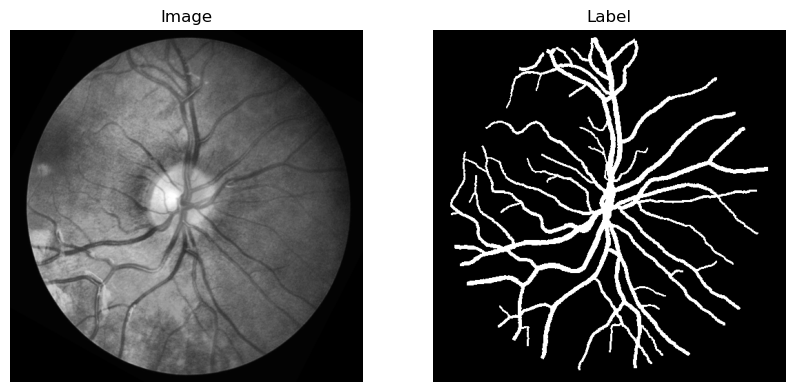

In [154]:
# Instantiate the dataset without masks_dir
dataset = RetinopathyDataset(images_dir, labels_dir, transform=custom_transform)

# Choose a number of images to display
num_images_to_display = 5

# Create a DataLoader with batch size 1 to load individual images
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Loop through the DataLoader and print the images
for i, (image, label) in enumerate(loader):
    # Break loop if the desired number of images is printed
    if i >= num_images_to_display:
        break
    
    # Convert tensors to numpy arrays for visualization
    image = image.squeeze().numpy()  # Assuming grayscale images
    label = label.squeeze().numpy()  # Assuming single-channel labels
    
    # Plot the image and label
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(label, cmap='gray')
    axes[1].set_title('Label')
    axes[1].axis('off')
    
    plt.show()


In [44]:
def train_unet(model, criterion, optimiser, dataloader, num_epochs, device, model_name):
    model.to(device)
    model.train()
    loss_container = []

    for epoch in range(num_epochs):
        total_loss = 0
        for idx, (image, mask) in enumerate(tqdm(dataloader)):
            (image, mask) = (image.to(device), mask.to(device))
            outputs = model(image)

            if isinstance(criterion, torch.nn.BCEWithLogitsLoss):
                loss = criterion(outputs, mask.float())
            
            elif isinstance(criterion, torch.nn.CrossEntropyLoss):
                loss = criterion(outputs, torch.squeeze(mask, dim=1))
            
            else:
                loss = criterion(outputs, mask)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        if len(loss_container) > 0  and avg_loss < min(loss_container) and model_name != None:
            torch.save(model, f"./models/{model_name}.pt")
        
        loss_container.append(avg_loss)
        print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")
    
    if model_name != None:
        torch.save(model, f"./models/{model_name}_{num_epochs}.pt")

    return loss_container

In [14]:
'''def train(model, criterion, optimizer, dataloader, num_epochs, device, tqdm):
    model.to(device)
    model.train()
    loss_container = []

    for epoch in range(num_epochs):
        total_loss = 0
        for idx, (image, mask) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)):
            unique_values, counts = np.unique(mask[0], return_counts=True)

            # Create Dictionary
            count_dict = dict(zip(unique_values, counts))
            #print("Counts of each value:")
            #print(count_dict)
            
            image, mask = image.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(image)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_container.append(avg_loss)
        print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")

    return loss_container


In [17]:
# Run this
# losses = train(model, criterion, optimizer, loader, 10, device, tqdm)
losses = train(model, criterion, optimizer, loader, 10, device)

c:\Users\Admin\anaconda3\lib\site-packages\torch\nn\modules\module.py:1150: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:30.)
  return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)
  0%|          | 0/16 [00:02<?, ?it/s]


AttributeError: 'FocalTverskyLoss' object has no attribute 'backward'

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.BCEWithLogitsLoss(),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device)),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4, dtype=torch.float32).to(device)),
                  DiceLoss(1),
                  FocalLoss(1, weights=torch.tensor(4).to(device)),
                  TverskyLoss(1),
                  TverskyLoss(1, 0.25),
                  TverskyLoss(1, 0.75),
                  FocalTverskyLoss(1),
                  LogCoshDice(1)]

model_names = ["FocalTverskyLoss"]

'''model_names = ["BCEnoPOS",
               "BCECalcPOS"
               "BCE4POS",
               "DiceLoss",
               "FocalLoss",
               "TverskyLossBase",
               "TverskyLoss25",
               "TverskyLoss75",
               "FocalTverskyLoss",
               "LogCoshDice"]'''

loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):

    model = uNetModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #0.001
    print(f"Training {model_names[idx]} model")
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               loader,
                               50,
                               device,
                               model_names[idx])
    
    loss_dataframe[model_names[idx]] = training_loss

    del model
    torch.cuda.empty_cache()
    gc.collect()

loss_dataframe.to_csv('binary.csv')

C:\Users\Admin\AppData\Local\Temp\ipykernel_22044\813099444.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device)),


Training FocalTverskyLoss model


100%|██████████| 10/10 [35:48<00:00, 214.83s/it]


Epoch 1 completed, training loss: 0.62


100%|██████████| 10/10 [44:41<00:00, 268.17s/it]


Epoch 2 completed, training loss: 0.48


100%|██████████| 10/10 [32:11<00:00, 193.14s/it]


Epoch 3 completed, training loss: 0.43


100%|██████████| 10/10 [40:06<00:00, 240.66s/it]


Epoch 4 completed, training loss: 0.40


100%|██████████| 10/10 [43:03<00:00, 258.36s/it]


Epoch 5 completed, training loss: 0.38


100%|██████████| 10/10 [39:29<00:00, 236.91s/it] 


Epoch 6 completed, training loss: 0.37


100%|██████████| 10/10 [35:51<00:00, 215.18s/it]


Epoch 7 completed, training loss: 0.35


100%|██████████| 10/10 [53:13<00:00, 319.37s/it]


Epoch 8 completed, training loss: 0.34


100%|██████████| 10/10 [36:48<00:00, 220.90s/it]


Epoch 9 completed, training loss: 0.34


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 10 completed, training loss: 0.33


100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


Epoch 11 completed, training loss: 0.32


100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


Epoch 12 completed, training loss: 0.31


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 13 completed, training loss: 0.31


100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


Epoch 14 completed, training loss: 0.30


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


Epoch 15 completed, training loss: 0.30


100%|██████████| 10/10 [02:10<00:00, 13.04s/it]


Epoch 16 completed, training loss: 0.29


100%|██████████| 10/10 [02:10<00:00, 13.09s/it]


Epoch 17 completed, training loss: 0.28


100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


Epoch 18 completed, training loss: 0.28


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 19 completed, training loss: 0.27


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 20 completed, training loss: 0.27


100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


Epoch 21 completed, training loss: 0.27


100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


Epoch 22 completed, training loss: 0.26


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 23 completed, training loss: 0.26


100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


Epoch 24 completed, training loss: 0.25


100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


Epoch 25 completed, training loss: 0.25


100%|██████████| 10/10 [02:09<00:00, 13.00s/it]


Epoch 26 completed, training loss: 0.25


100%|██████████| 10/10 [02:09<00:00, 12.98s/it]


Epoch 27 completed, training loss: 0.24


100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


Epoch 28 completed, training loss: 0.24


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


Epoch 29 completed, training loss: 0.24


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 30 completed, training loss: 0.23


100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


Epoch 31 completed, training loss: 0.23


100%|██████████| 10/10 [02:07<00:00, 12.77s/it]


Epoch 32 completed, training loss: 0.23


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 33 completed, training loss: 0.23


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 34 completed, training loss: 0.22


100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


Epoch 35 completed, training loss: 0.22


100%|██████████| 10/10 [02:09<00:00, 12.96s/it]


Epoch 36 completed, training loss: 0.22


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 37 completed, training loss: 0.21


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 38 completed, training loss: 0.21


100%|██████████| 10/10 [02:07<00:00, 12.76s/it]


Epoch 39 completed, training loss: 0.21


100%|██████████| 10/10 [02:10<00:00, 13.00s/it]


Epoch 40 completed, training loss: 0.21


100%|██████████| 10/10 [02:09<00:00, 12.98s/it]


Epoch 41 completed, training loss: 0.21


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 42 completed, training loss: 0.20


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


Epoch 43 completed, training loss: 0.20


100%|██████████| 10/10 [02:10<00:00, 13.08s/it]


Epoch 44 completed, training loss: 0.20


100%|██████████| 10/10 [02:10<00:00, 13.07s/it]


Epoch 45 completed, training loss: 0.20


100%|██████████| 10/10 [02:07<00:00, 12.76s/it]


Epoch 46 completed, training loss: 0.19


100%|██████████| 10/10 [02:10<00:00, 13.01s/it]


Epoch 47 completed, training loss: 0.19


100%|██████████| 10/10 [02:09<00:00, 12.99s/it]


Epoch 48 completed, training loss: 0.19


100%|██████████| 10/10 [02:10<00:00, 13.06s/it]


Epoch 49 completed, training loss: 0.19


100%|██████████| 10/10 [02:09<00:00, 12.95s/it]


Epoch 50 completed, training loss: 0.19


IndexError: list index out of range

Save Model Weights

In [162]:
torch.save(model.state_dict(), 'vesselmodel_finalv9_010424.pth')

In [35]:
# Load model

model = uNetModel()

# Load the saved state dictionary
state_dict = torch.load('vesselmodel_finalv8_300324.pth')

# Load the state dictionary into the model
model.load_state_dict(state_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TypeError: Expected state_dict to be dict-like, got <class '__main__.uNetModel'>.

In [54]:
model = torch.load('FocalTverskyLoss_50_0.0001.pt')

In [40]:
total_images = len(dataset)

num_images_to_process = min(100, total_images)

In [41]:
def save_segmented_images(dataset, model, device, save_dir="segmented_images", num_images=100, mean=None, std=None):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)
    for idx in range(num_images):
        image, _ = dataset[idx]
        image_unsq = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_unsq)
        pred = torch.sigmoid(output).cpu()
        pred = (pred > 0.5).float()
        pred_np = pred.squeeze().numpy()

        if mean is not None and std is not None and pred_np.ndim == 2:
            # Since it's grayscale, use only the first mean and std values
            pred_np = (pred_np * std[0]) + mean[0]
            # Ensure the array is clipped to the range [0, 1] after reversing normalization
            pred_np = np.clip(pred_np, 0, 1)

        # Convert the tensor to range 0-255 and type 'uint8' for saving as an image
        pred_np = (pred_np * 255).astype(np.uint8)

        save_path = os.path.join(save_dir, f"segmented_{idx}.png")
        cv2.imwrite(save_path, pred_np)

# mean and std should be the same values used for normalization during preprocessing
save_segmented_images(dataset, model, device, num_images=num_images_to_process, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [47]:
def visualize_comparisons(dataset, model, device, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    for idx in range(num_samples):
        image, label = dataset[idx]
        image_unsq = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image_unsq)
            
        pred = torch.sigmoid(output).cpu()
        pred = (pred > 0.5).float()
        
        image_np = image.squeeze().cpu().numpy()
        label_np = label.squeeze().cpu().numpy()
        pred_np = pred.squeeze().numpy()
        
        axs[idx, 0].imshow(image_np, cmap='gray')
        axs[idx, 0].set_title('Original Image')
        axs[idx, 1].imshow(pred_np, cmap='gray')
        axs[idx, 1].set_title('U-Net Segmentation')
        axs[idx, 2].imshow(label_np, cmap='gray')
        axs[idx, 2].set_title('Manual Labeling')
        
        for ax in axs[idx]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [98]:
save_segmented_images(dataset, model, device, save_dir="segmented_images", num_images=len(dataset))



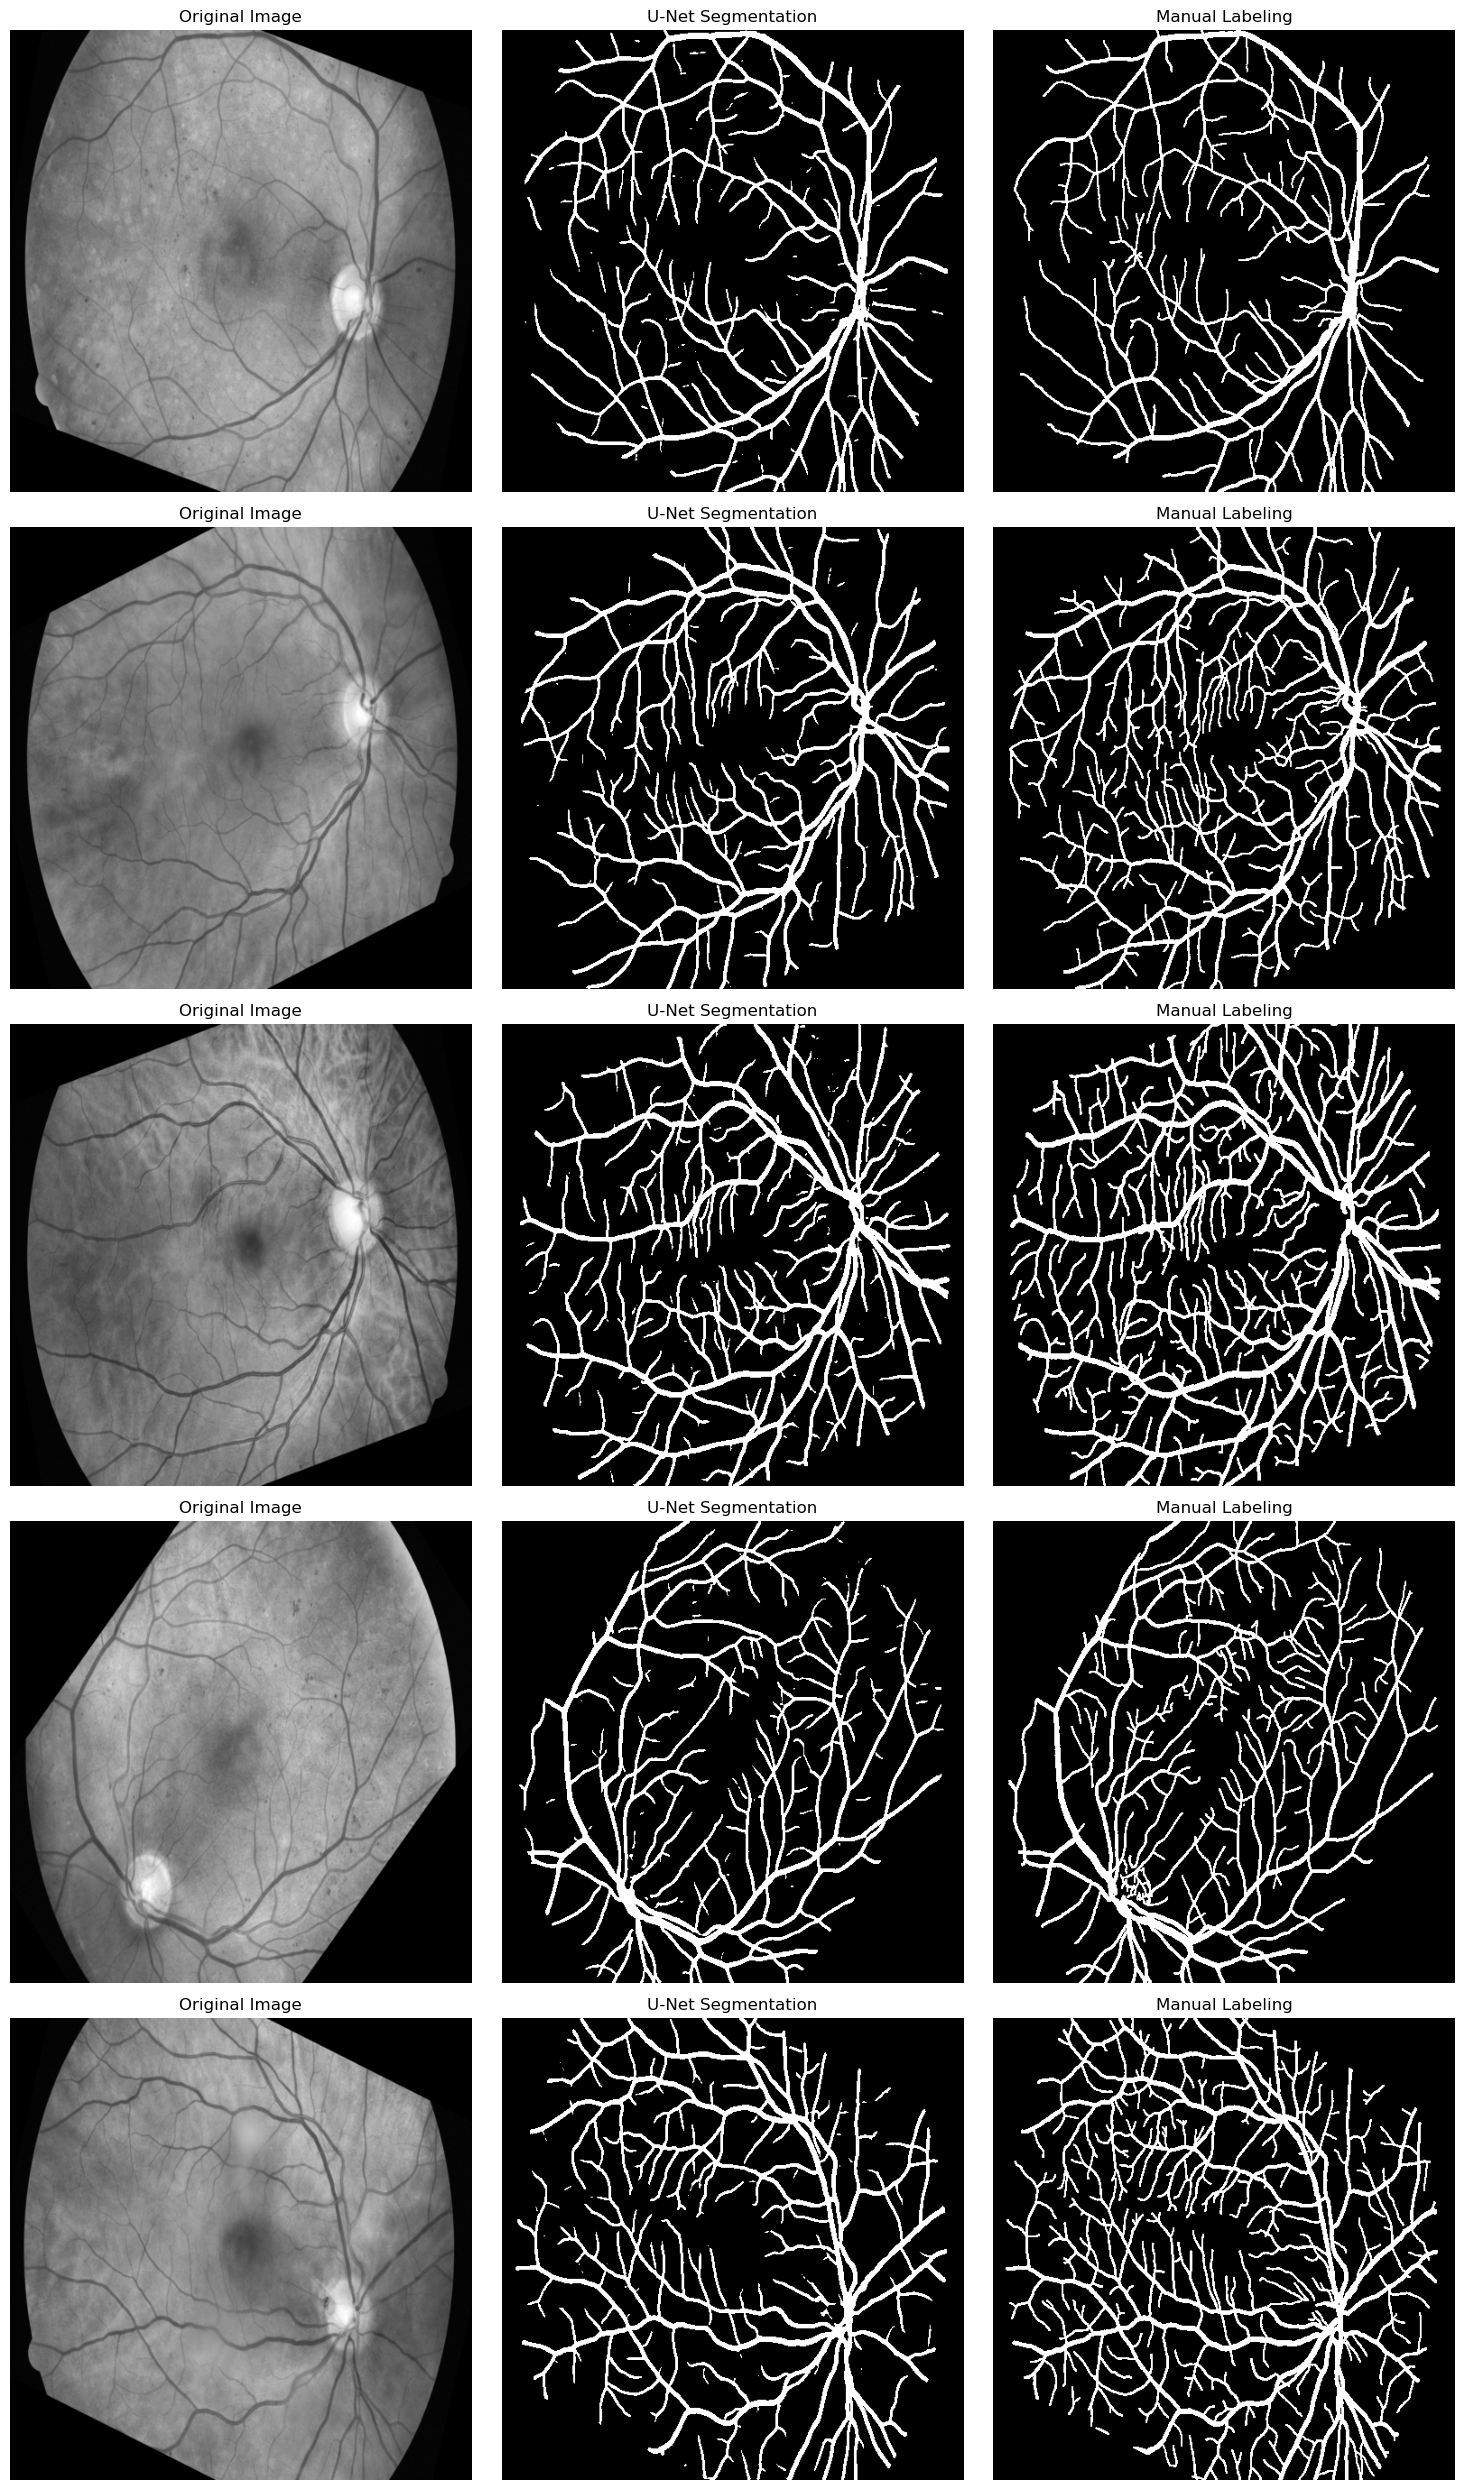

In [55]:
visualize_comparisons(dataset, model, device, num_samples=5)

In [18]:
def jaccard_index(preds, labels):
    """
    Args:
    preds: Predicted tensor.
    labels: Ground truth tensor.
    
    Returns:
    float: Jaccard Index.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    
    # Calculate Intersection and Union.
    intersection = (preds * labels).sum()
    union = preds.sum() + labels.sum() - intersection
    
    # Compute Jaccard Index
    jaccard = intersection / union
    
    return jaccard.item()


In [19]:
def dice_coefficient(preds, labels):
    """
    Args:
    preds: Predicted tensor.
    labels: Ground truth tensor.
    
    Returns:
    float: Dice Coefficient.
    """
    # Ensure the predictions are binary
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    
    # Calculate Intersection and twice the sum of both predictions and labels
    intersection = (preds * labels).sum()
    total = preds.sum() + labels.sum()
    
    # Compute Dice Coefficient
    dice = (2. * intersection) / total
    
    return dice.item()


In [56]:
def evaluate_model(model, dataloader, device):
    model.eval() 
    jaccard_scores = []
    dice_scores = []

    with torch.no_grad(): 
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5  # Threshold predictions
            preds = preds.float()

            # Calculate metrics for each batch and append to list
            jaccard_scores.append(jaccard_index(preds, masks))
            dice_scores.append(dice_coefficient(preds, masks))

    # Compute average scores
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)
    
    print(f"Average Jaccard Index: {avg_jaccard}")
    print(f"Average Dice Coefficient: {avg_dice}")

evaluate_model(model, dataloader=loader, device=device)

Average Jaccard Index: 0.7134620249271393
Average Dice Coefficient: 0.8326858341693878
